# CIFAR-10 Classification Project

This project aims to work on image recognition models using the CIFAR-10 dataset. CNN architectures and transfer-learning methods, using pre-trained models on imagenet will be used.

## 1. Import & Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# import all relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Activation, GlobalAveragePooling2D, Input
)

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_dense
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [48]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Rescaling

In [2]:
# seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load & Visualize Data

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes:
"airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In [3]:
# load & split data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# define class names
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


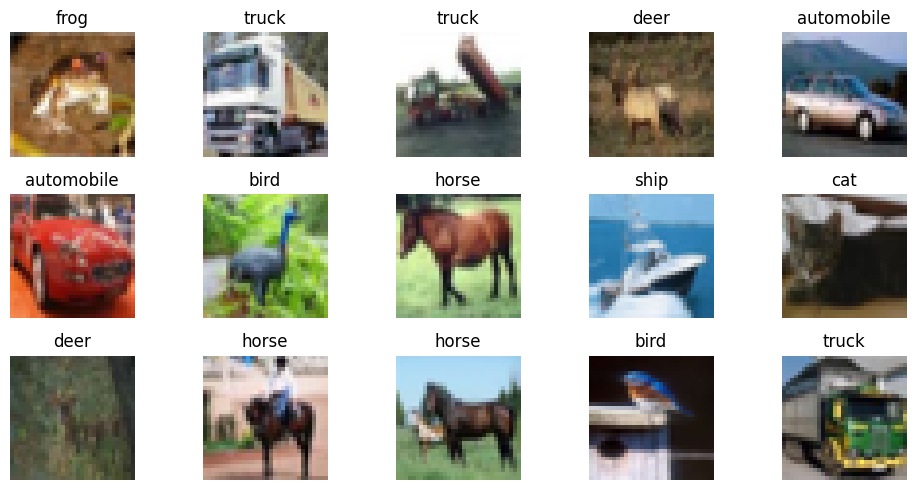

In [4]:
# visualize examples
plt.figure(figsize=(10, 5))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# dataset shapes
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (50000, 32, 32, 3) X_test: (10000, 32, 32, 3)
y_train: (50000, 1) y_test: (10000, 1)


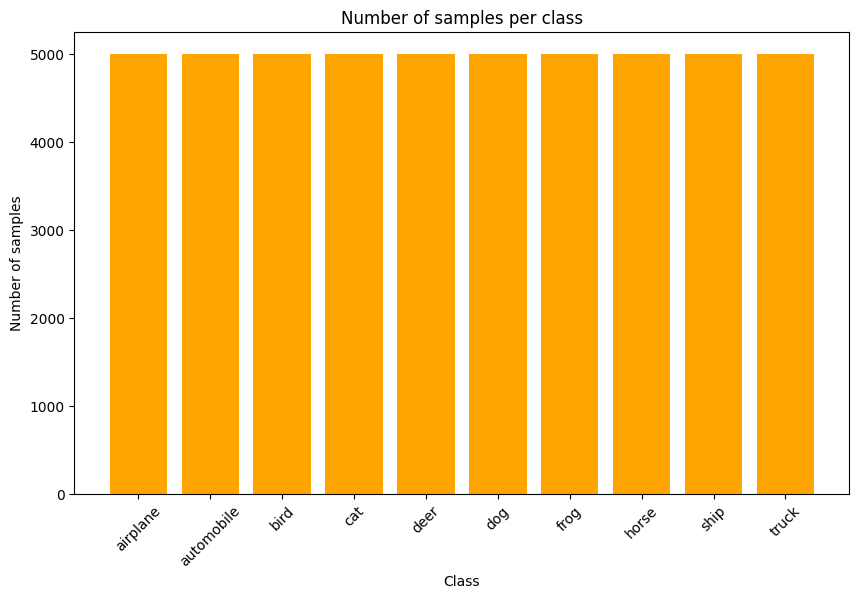

In [6]:
# class distribution
labels = y_train.flatten()
class_counts = Counter(labels)
plt.figure(figsize=(10, 6))
plt.bar(class_names, [class_counts[i] for i in range(10)], color="orange")
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of samples per class')
plt.xticks(rotation=45)
plt.show()

The classes are evenly distributed.

## 3. Preprocessing

For the data reprocessing, flattening of the target data to 1D is needed as preparation for encoding the classes.

Normalization of the features will help training the models.



In [7]:
# flatten label arrays
y_train = y_train.flatten()
y_test = y_test.flatten()

In [8]:
# one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [9]:
# normalize pixel color values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## 4. Evaluation of Models

For constant cross-checking between chosen model architectures and finetuning parameters, a evaluation function is defined, lisitng the accuracy according to step iteration step.

In [10]:
results = []

def evaluate_model(model, model_name, X_test, y_test=None, save_model=False, filename=None):

    # Detect tf.data.Dataset automatically
    is_dataset = isinstance(X_test, tf.data.Dataset)

    # Case 1: tf.data.Dataset
    if is_dataset:
        loss, acc = model.evaluate(X_test, verbose=0)
        results.append({
            "Model": model_name,
            "Loss": loss,
            "Accuracy": acc
        })
        print(f"{model_name} -> Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")
        return None, None

    # Case 2: Numpy-style input (X_test, y_test)
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)  # FIXED

    loss, acc = model.evaluate(X_test, y_test, verbose=0)  # FIXED
    results.append({
        "Model": model_name,
        "Loss": loss,
        "Accuracy": acc
    })
    print(f"{model_name} -> Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

    if save_model and filename:
        model.save(filename)
        print(f"Saved model to {filename}")

    return y_pred, y_true

In [11]:
# early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

## 5. Baseline CNN Model

In [12]:
# creating baseline model architecture
model_base = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# compile
model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_base = model_base.fit(X_train, y_train_cat, epochs=20, validation_split=0.2, shuffle=True)
evaluate_model(model_base, "Baseline CNN", X_test, y_test_cat)

# save baseline model
model_base.save("/content/drive/MyDrive/Ironhack/models/CIFAR-10_base_model.keras")

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.3788 - loss: 1.7153 - val_accuracy: 0.5747 - val_loss: 1.2268
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5865 - loss: 1.1674 - val_accuracy: 0.6215 - val_loss: 1.0925
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6452 - loss: 1.0128 - val_accuracy: 0.6504 - val_loss: 1.0261
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6820 - loss: 0.9070 - val_accuracy: 0.6596 - val_loss: 0.9996
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7146 - loss: 0.8213 - val_accuracy: 0.6616 - val_loss: 0.9872
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7413 - loss: 0.7462 - val_accuracy: 0.6654 - val_loss: 0.9977
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7672 - loss: 0.6743 - val_accuracy: 0.6678 - val_loss: 1.0407
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7914 - loss: 0.6012 -

#### Baseline Evaluation & Visualization


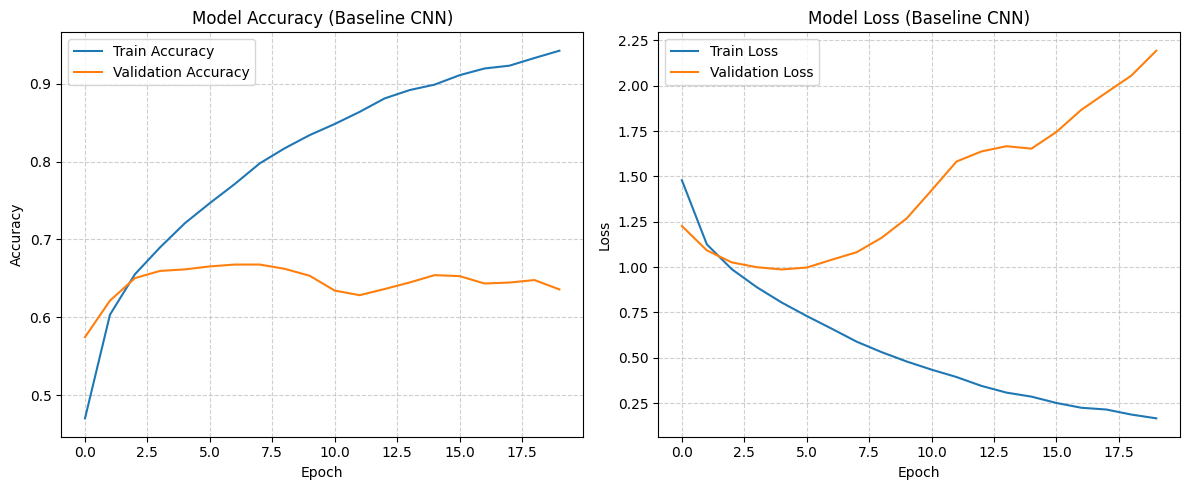

In [14]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_base.history['accuracy'], label='Train Accuracy')
plt.plot(history_base.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Baseline CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Baseline CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [15]:
# Predict class probabilities
y_pred_probs = model_base.predict(X_test)

# Convert probabilities to class predictions
y_pred = y_pred_probs.argmax(axis=1) # transfer probabilities back to classes
y_true = y_test  # original integer labels

#report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

    airplane       0.68      0.68      0.68      1000
  automobile       0.75      0.76      0.75      1000
        bird       0.53      0.49      0.51      1000
         cat       0.51      0.40      0.45      1000
        deer       0.64      0.47      0.54      1000
         dog       0.62      0.44      0.52      1000
        frog       0.65      0.73      0.69      1000
       horse       0.56      0.78      0.65      1000
        ship       0.69      0.80      0.74      1000
       truck       0.68      0.77      0.72      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



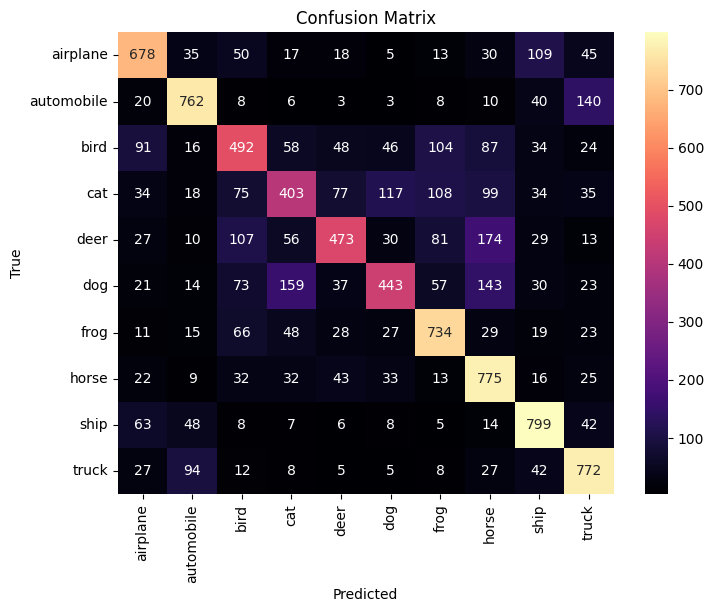

In [16]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="magma")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

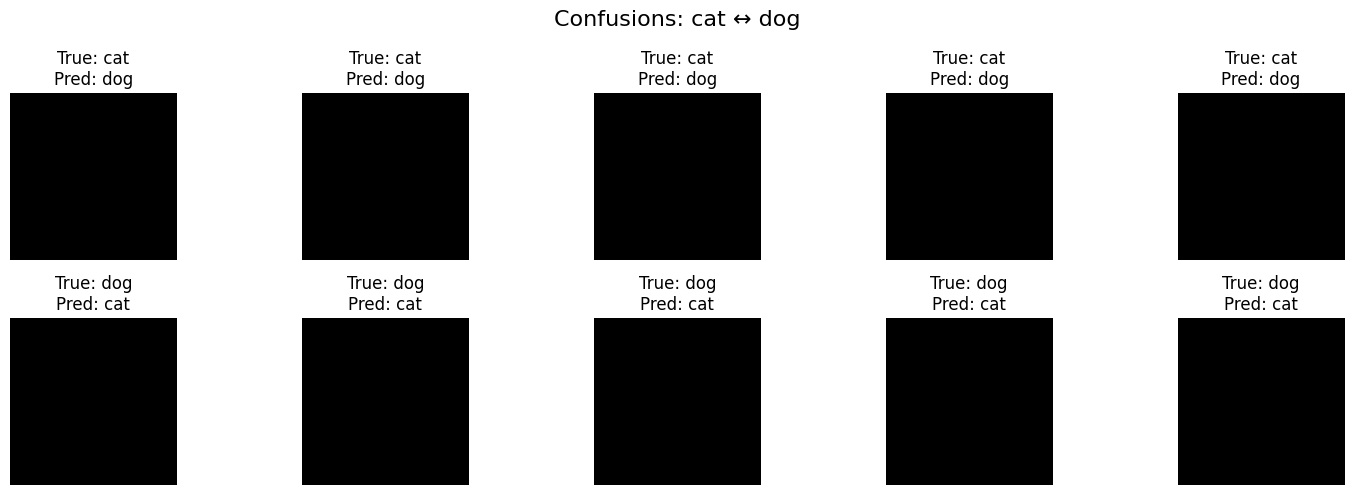

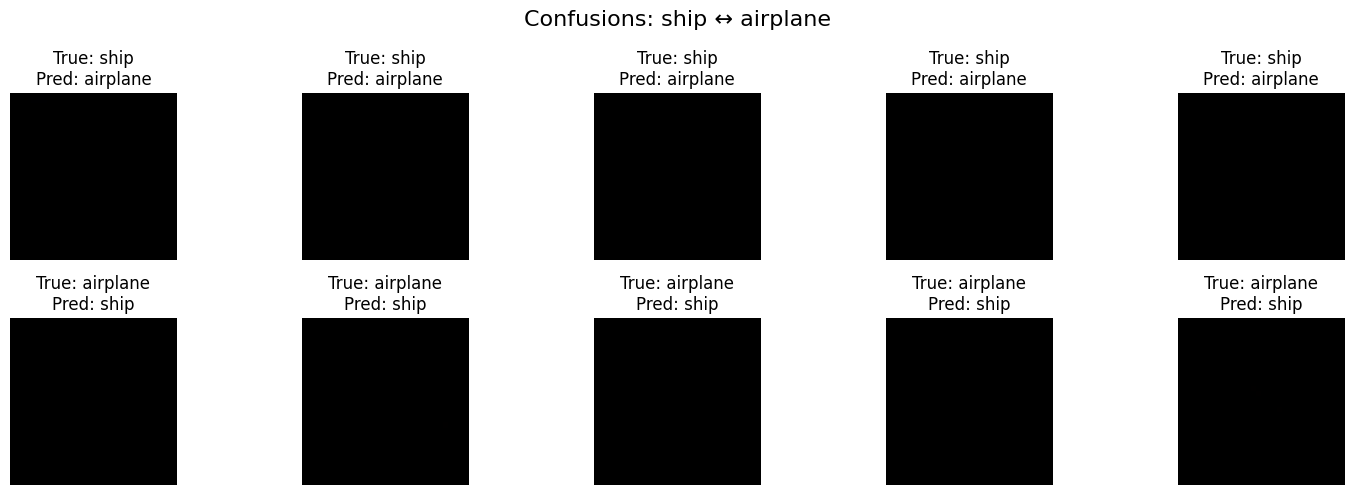

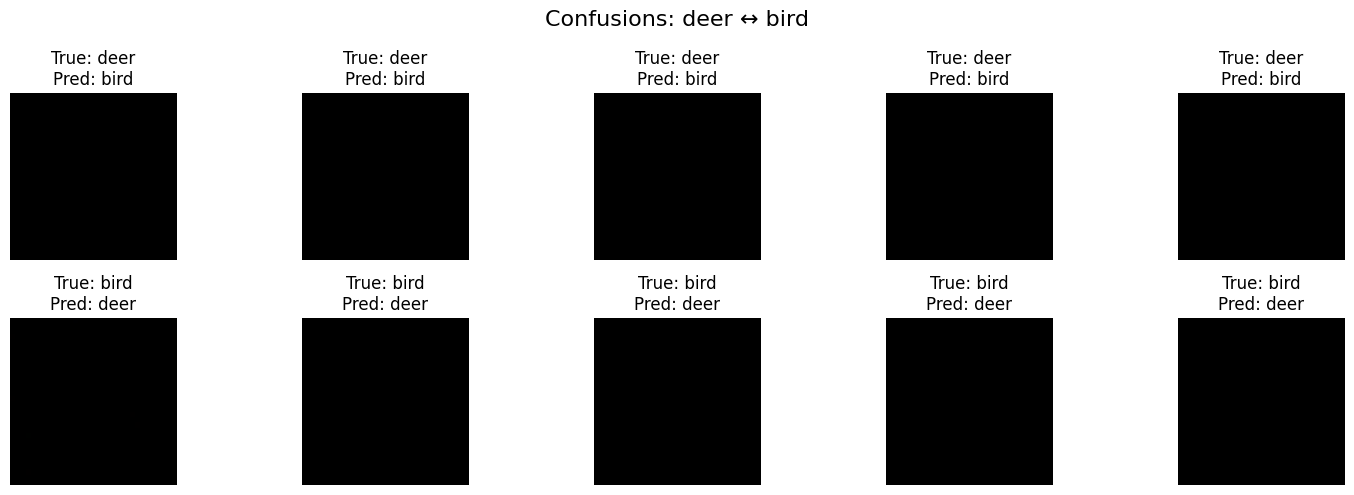

In [17]:
# y_pred and y_true to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Confusing class pairs to inspect
confusing_pairs = [
    (3, 5),  # cat vs dog
    (8, 0),  # ship vs airplane
    (4, 2)  # deer vs bird
]

def show_confusion_examples(y_true, y_pred, X, class1, class2, n=5):
    idx_confused_1 = np.where((y_true == class1) & (y_pred == class2))[0]
    idx_confused_2 = np.where((y_true == class2) & (y_pred == class1))[0]

    np.random.shuffle(idx_confused_1)
    np.random.shuffle(idx_confused_2)

    fig, axes = plt.subplots(2, n, figsize=(15, 5))
    fig.suptitle(f"Confusions: {class_names[class1]} ↔ {class_names[class2]}", fontsize=16)

    for i in range(n):
        # True class1 predicted class2
        if i < len(idx_confused_1):
            ax = axes[0, i]
            img = X[idx_confused_1[i]]
            if not isinstance(img, np.ndarray):
                img = img.numpy()
            ax.imshow(np.clip(img / 255.0, 0, 1))
            ax.set_title(f"True: {class_names[class1]}\nPred: {class_names[class2]}")
            ax.axis('off')
        else:
            axes[0, i].axis('off')

        # True class2 predicted class1
        if i < len(idx_confused_2):
            ax = axes[1, i]
            img = X[idx_confused_2[i]]
            if not isinstance(img, np.ndarray):
                img = img.numpy()
            ax.imshow(np.clip(img / 255.0, 0, 1))
            ax.set_title(f"True: {class_names[class2]}\nPred: {class_names[class1]}")
            ax.axis('off')
        else:
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

for class1, class2 in confusing_pairs:
    show_confusion_examples(y_true, y_pred, X_test, class1, class2)

## 6. Improving CNN Models

#### 6.1 More Layers Version 1

In [18]:
model_ml_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model_ml_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_ml_1 = model_ml_1.fit(X_train, y_train_cat, epochs=20, batch_size=64, validation_data=(X_test, y_test_cat), callbacks=[early_stop])
evaluate_model(model_ml_1, "CNN More Layers v1", X_test, y_test_cat)

# save baseline model
model_ml_1.save("/content/drive/MyDrive/Ironhack/models/CIFAR-10_cnn_ml_1.keras")

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3019 - loss: 1.8755 - val_accuracy: 0.5288 - val_loss: 1.3229
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5300 - loss: 1.3062 - val_accuracy: 0.6025 - val_loss: 1.1343
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6071 - loss: 1.1182 - val_accuracy: 0.6542 - val_loss: 0.9837
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6561 - loss: 0.9861 - val_accuracy: 0.6890 - val_loss: 0.9065
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6908 - loss: 0.8905 - val_accuracy: 0.7055 - val_loss: 0.8587
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7128 - loss: 0.8196 - val_accuracy: 0.7112 - val_loss: 0.8501
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7315 - loss: 0.7690 - val_accuracy: 0.7180 - val_loss: 0.8330
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7493 - loss: 0.7151 - val_accuracy: 

#### 6.2 More Layers Version 2

In [20]:
model_ml_2 = Sequential([
    Conv2D(32, (3,3), padding="same", input_shape=(32,32,3)),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), padding="same"),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), padding="same"),
    BatchNormalization(), Activation('relu'),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_ml_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_ml_2 = model_ml_2.fit(X_train, y_train_cat, epochs=60, batch_size=64, validation_data=(X_test, y_test_cat), callbacks=[early_stop])
evaluate_model(model_ml_2, "CNN More Layers v2", X_test, y_test_cat)

# save baseline model
model_ml_2.save("/content/drive/MyDrive/Ironhack/models/CIFAR-10_cnn_ml_2.keras")

Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.3657 - loss: 1.7292 - val_accuracy: 0.4538 - val_loss: 1.4629
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5521 - loss: 1.2302 - val_accuracy: 0.5732 - val_loss: 1.1876
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6117 - loss: 1.0821 - val_accuracy: 0.4490 - val_loss: 1.7122
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6454 - loss: 0.9943 - val_accuracy: 0.6150 - val_loss: 1.0804
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6757 - loss: 0.9202 - val_accuracy: 0.5455 - val_loss: 1.3352
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6966 - loss: 0.8666 - val_accuracy: 0.4753 - val_loss: 1.7953
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7168 - loss: 0.8066 - val_accuracy: 0.5706 - val_loss: 1.3299
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7318 - loss: 0.7645 - val_accuracy: 

### 6.3 BatchNorm & GlobalAveragePooling



In [21]:
model_ml_2 = load_model("/content/drive/MyDrive/Ironhack/models/CIFAR-10_cnn_ml_2.keras")

model_ml_2_GAP = Sequential([
        Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])



In [22]:
model_ml_2_GAP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ml_2_GAP.fit(X_train, y_train_cat, epochs=60, batch_size=64, validation_data=(X_test, y_test_cat), callbacks=[early_stop])
evaluate_model(model_ml_2_GAP, "CNN More Layers v2 GAP", X_test, y_test_cat)
model_ml_2_GAP.save("/content/drive/MyDrive/Ironhack/models/CIFAR-10_cnn_ml_2_GAP.keras")

Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3702 - loss: 1.7126 - val_accuracy: 0.3663 - val_loss: 1.9610
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5580 - loss: 1.2257 - val_accuracy: 0.4906 - val_loss: 1.4533
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6101 - loss: 1.0913 - val_accuracy: 0.5638 - val_loss: 1.2306
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6431 - loss: 1.0028 - val_accuracy: 0.4846 - val_loss: 1.6128
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6715 - loss: 0.9257 - val_accuracy: 0.5631 - val_loss: 1.3054
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6982 - loss: 0.8664 - val_accuracy: 0.5687 - val_loss: 1.3439
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7126 - loss: 0.8147 - val_accuracy: 0.5653 - val_loss: 1.3812
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7303 - loss: 0.7655 - val_accuracy: 0

### 6.4 Optimizer SGD

In [23]:
# Load pre-trained baseline model
model_sgd = load_model("/content/drive/MyDrive/Ironhack/models/CIFAR-10_base_model.keras")

# Re-compile with SGD optimizer
sgd_opt = SGD(learning_rate=1e-3, momentum=0.9)
model_sgd.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Continue training / fine-tuning with SGD
history_sgd = model_sgd.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop]
)

# Save & evaluate
model_sgd.save("/content/drive/MyDrive/Ironhack/models/CIFAR-10_base_model+SGD.keras")
evaluate_model(model_sgd, "Baseline + SGD", X_test, y_test_cat)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8645 - loss: 0.5734 - val_accuracy: 0.6599 - val_loss: 1.6424
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8819 - loss: 0.4584 - val_accuracy: 0.6631 - val_loss: 1.5268
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8883 - loss: 0.4234 - val_accuracy: 0.6656 - val_loss: 1.4779
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8941 - loss: 0.4003 - val_accuracy: 0.6651 - val_loss: 1.4554
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8956 - loss: 0.3858 - val_accuracy: 0.6701 - val_loss: 1.4380
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8987 - loss: 0.3737 - val_accuracy: 0.6689 - val_loss: 1.4284
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9023 - loss: 0.3620 - val_accuracy: 0.6710 - val_loss: 1.4190
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9045 - loss: 0.3526 - val_accuracy: 0

(array([3, 8, 8, ..., 5, 4, 7]), array([3, 8, 8, ..., 5, 1, 7]))

### 6.5 Evaluation comparison

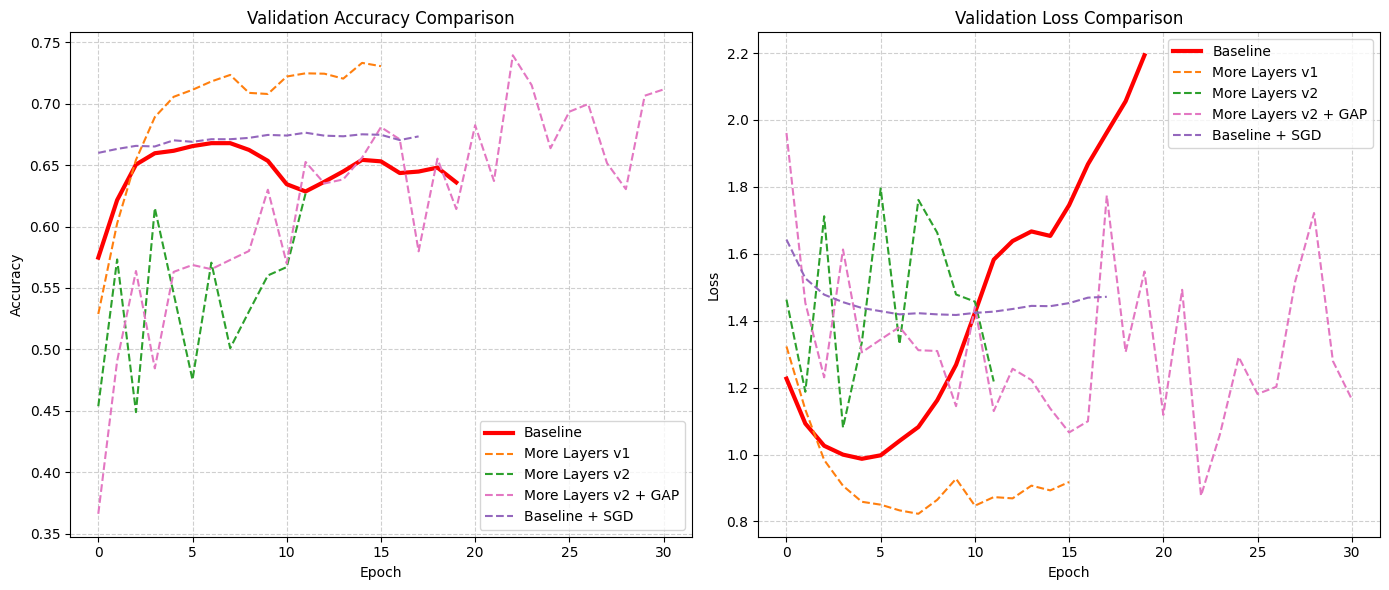

In [25]:
# Combine all histories in a dictionary for easy looping
histories = {
    "Baseline": history_base,
    "More Layers v1": history_ml_1,
    "More Layers v2": history_ml_2,
    "More Layers v2 + GAP": model_ml_2_GAP.history,
    "Baseline + SGD": model_sgd.history
}

plt.figure(figsize=(14, 6))

# Define styles: highlight baseline
styles = {
    "Baseline": {"color": "red", "linewidth": 3, "linestyle": "-"},
    "More Layers v1": {"color": "C1", "linewidth": 1.5, "linestyle": "--"},
    "More Layers v2": {"color": "C2", "linewidth": 1.5, "linestyle": "--"},
    "More Layers v2 + GAP": {"color": "C6", "linewidth": 1.5, "linestyle": "--"},
    "Baseline + SGD": {"color": "C4", "linewidth": 1.5, "linestyle": "--"},
}

# Accuracy Plot
plt.subplot(1, 2, 1)
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=f'{name}', **styles[name])
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss Plot
plt.subplot(1, 2, 2)
for name, hist in histories.items():
    plt.plot(hist.history['val_loss'], label=f'{name}', **styles[name])
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## 7. Transfer Learning

In [26]:
# resize images to 96x96
X_train_resized = tf.image.resize(X_train, (96, 96)).numpy()
X_test_resized = tf.image.resize(X_test, (96, 96)).numpy()

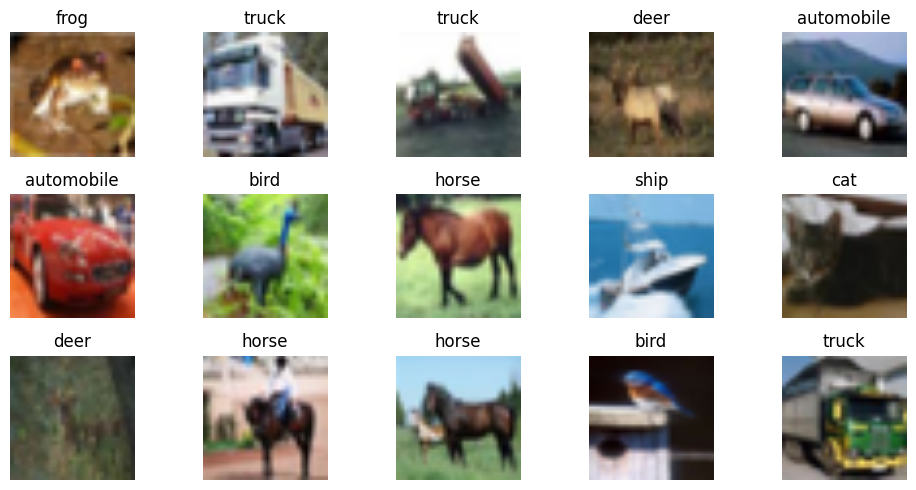

In [27]:
X_train_resized_int = tf.cast(X_train_resized * 255.0, tf.uint8).numpy()

# plot figure
plt.figure(figsize=(10, 5))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_train_resized_int[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 7.1 MobileNetV2

In [28]:
# mobile net v2 model
mobilenet_base = MobileNetV2(input_shape=(96,96,3), include_top=False, weights='imagenet')

# freeze all layers
mobilenet_base.trainable = False

# add activation
model_mnet = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model_mnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mnet = model_mnet.fit(X_train_resized, y_train_cat, validation_split=0.2, epochs=60, batch_size=64, callbacks=[early_stop])
evaluate_model(model_mnet, "MobileNetV2 Frozen", X_test_resized, y_test_cat)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.6890 - loss: 0.9051 - val_accuracy: 0.7904 - val_loss: 0.6036
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8047 - loss: 0.5644 - val_accuracy: 0.8002 - val_loss: 0.5697
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8261 - loss: 0.4989 - val_accuracy: 0.8022 - val_loss: 0.5680
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8427 - loss: 0.4494 - val_accuracy: 0.7973 - val_loss: 0.5811
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8578 - loss: 0.4080 - val_accuracy: 0.7968 - val_loss: 0.5906
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8735 - loss: 0.3712 - val_accuracy: 0.7899 - val_loss: 0.6344
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8860 - loss: 0.3332 - val_accuracy: 0.7847 - val_loss: 0.6665
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms

(array([3, 8, 8, ..., 5, 1, 7]), array([3, 8, 8, ..., 5, 1, 7]))

In [30]:
# save
model_mnet.save("/content/drive/MyDrive/Ironhack/models/MobileNetV2_Frozen.keras")

#### 7.1.1 MobilNetV2 with unfrozen layers

In [31]:
# load model
model_mnet_unfreeze = load_model("/content/drive/MyDrive/Ironhack/models/MobileNetV2_Frozen.keras")

# acces base
mobilenet_base = model_mnet_unfreeze.layers[0]

# unfreeze the last 60 layers
for layer in mobilenet_base.layers[:-60]:
    layer.trainable = False
for layer in mobilenet_base.layers[-60:]:
    layer.trainable = True

In [32]:
# re-compile w low leanring rate
model_mnet_unfreeze.compile(
    optimizer=Adam(1e-5),  # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [33]:
# continue training (fine-tuning)
history_finetune = model_mnet_unfreeze.fit(
    X_train_resized, y_train_cat,
    validation_split=0.2,
    epochs=60,
    batch_size=64,
    callbacks=[early_stop]
)

# Evaluate
evaluate_model(model_mnet_unfreeze, "MobileNetV2 Fine-Tuned", X_test_resized, y_test_cat)

# save
model_mnet_unfreeze.save("/content/drive/MyDrive/Ironhack/models/MobileNetV2_FineTuned.keras")

Epoch 1/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.6937 - loss: 0.9769 - val_accuracy: 0.8157 - val_loss: 0.5792
Epoch 2/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8360 - loss: 0.4912 - val_accuracy: 0.8448 - val_loss: 0.4858
Epoch 3/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8825 - loss: 0.3532 - val_accuracy: 0.8534 - val_loss: 0.4532
Epoch 4/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9161 - loss: 0.2626 - val_accuracy: 0.8552 - val_loss: 0.4436
Epoch 5/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9439 - loss: 0.1951 - val_accuracy: 0.8590 - val_loss: 0.4441
Epoch 6/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9633 - loss: 0.1424 - val_accuracy: 0.8619 - val_loss: 0.4495
Epoch 7/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9789 - loss: 0.1008 - val_accuracy: 0.8630 - val_loss: 0.4586
Epoch 8/60
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9895 - loss: 0.0689 - val_acc

### 7.2 DenseNet121

In [34]:
# batch-wise resizing images to 224x224

# set parameters
IMG_SIZE = 224
batch_size = 64

#preprocessing function
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = preprocess_input(image)
    return image, label

# dataset
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
            .shuffle(10000)
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

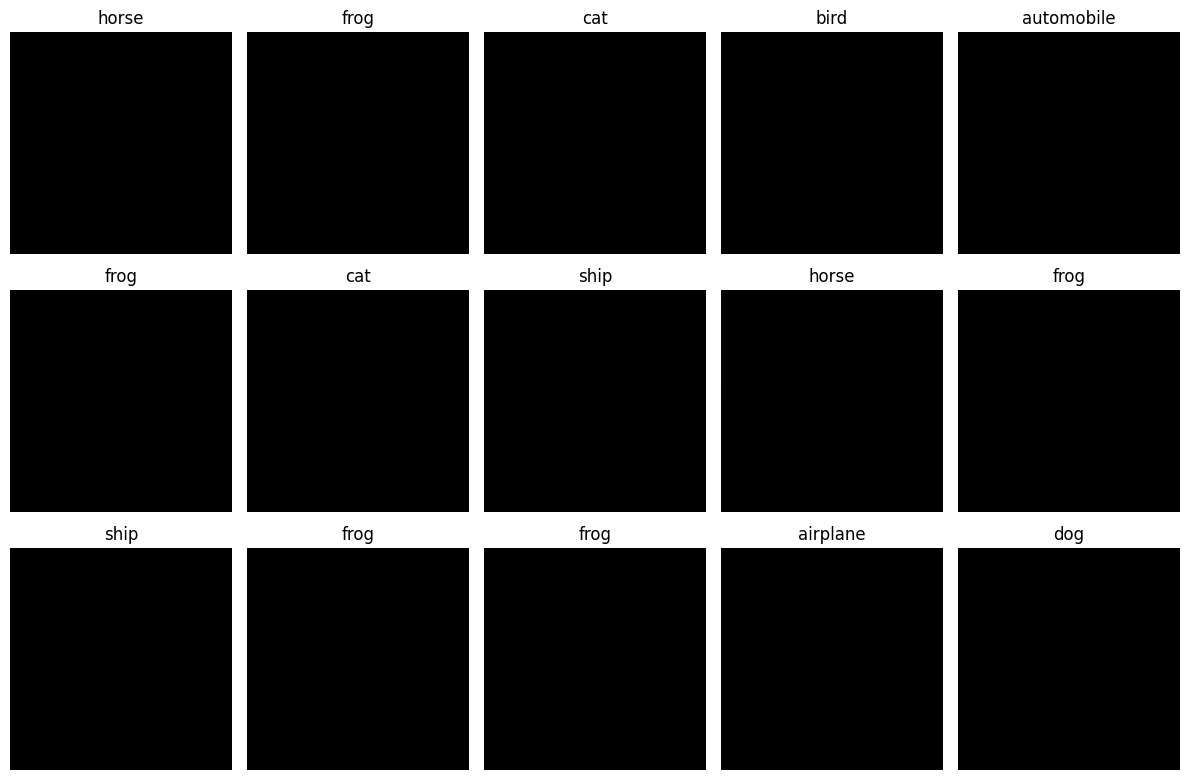

In [35]:
# take one batch from dataset
images, labels = next(iter(train_ds))

# convert tensors to numpy for plotting
images = images.numpy()
labels = labels.numpy()

# plot first 15 images (3 rows x 5 columns)
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

#### 7.2.1 DenseNet121 Frozen

In [36]:
densenet_base = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

densenet_base.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
# add activation layers
model_dennet121 = Sequential([
    densenet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model_dennet121.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mnet = model_dennet121.fit(train_ds, validation_data=test_ds, epochs=60, batch_size=64, callbacks=[early_stop])
evaluate_model(model_dennet121, "DenseNet121 Frozen", test_ds)


Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 136ms/step - accuracy: 0.7039 - loss: 0.8598 - val_accuracy: 0.7992 - val_loss: 0.5921
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8239 - loss: 0.5079 - val_accuracy: 0.8285 - val_loss: 0.5051
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8414 - loss: 0.4604 - val_accuracy: 0.8271 - val_loss: 0.5015
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8472 - loss: 0.4421 - val_accuracy: 0.8344 - val_loss: 0.4843
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8569 - loss: 0.4079 - val_accuracy: 0.8309 - val_loss: 0.4903
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8612 - loss: 0.3963 - val_accuracy: 0.8436 - val_loss: 0.4664
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8684 - loss: 0.3813 - val_accuracy: 0.8422 - val_loss: 0.4709
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.8765 - loss: 0.3561 

(None, None)

In [38]:
# save
model_dennet121.save("/content/drive/MyDrive/Ironhack/models/DenseNet121_Freeze.keras")

#### 7.2.2 DenseNet Fine Tuning

In [39]:
# load model
model_dennet121_unfreeze = load_model("/content/drive/MyDrive/Ironhack/models/DenseNet121_Freeze.keras")

# acces base
dennet_base = model_dennet121_unfreeze.layers[0]

# unfreeze the last 60 layers
for layer in dennet_base.layers[:-60]:
    layer.trainable = False
for layer in dennet_base.layers[-60:]:
    layer.trainable = True

In [40]:
# re-compile w low leanring rate
model_dennet121_unfreeze.compile(
    optimizer=Adam(1e-5),  # lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [41]:

model_dennet121_unfreeze.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mnet = model_dennet121_unfreeze.fit(train_ds, validation_data=test_ds, epochs=60, batch_size=64, callbacks=[early_stop])
evaluate_model(model_dennet121_unfreeze, "DenseNet121 FineTuned", test_ds)
model_dennet121_unfreeze.save("/content/drive/MyDrive/Ironhack/models/DenseNet121_FineTuned.keras")


Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 153s 146ms/step - accuracy: 0.8305 - loss: 0.5103 - val_accuracy: 0.8488 - val_loss: 0.4605
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.8973 - loss: 0.2907 - val_accuracy: 0.8631 - val_loss: 0.4225
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.9217 - loss: 0.2142 - val_accuracy: 0.8814 - val_loss: 0.3646
Epoch 4/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.9393 - loss: 0.1669 - val_accuracy: 0.8847 - val_loss: 0.3996
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.9543 - loss: 0.1282 - val_accuracy: 0.8908 - val_loss: 0.3981
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.9657 - loss: 0.0944 - val_accuracy: 0.8871 - val_loss: 0.4195
Epoch 7/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.9710 - loss: 0.0793 - val_accuracy: 0.8878 - val_loss: 0.4367
Epoch 8/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 94ms/step - accuracy: 0.9734 - loss: 0.0765 

### 7.3 DenseNet121 Fine Tune with Augmentation

In [42]:
# batch-wise resizing images to 224x224

# set parameters
IMG_SIZE = 224
batch_size = 64

# augmenation
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# preprocessing
def preprocess_aug(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# dataset augmentation applied
train_ds_aug = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
    .shuffle(10000)
    .map(preprocess_aug, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda x, y: (data_aug(x, training=True), y))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds_aug = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
    .map(preprocess_aug, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# take one batch
images, labels = next(iter(train_ds_aug))

# convert tensors to numpy
images = images.numpy()
labels = labels.numpy()

# plot first 15 images
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])  # keep float32 [0,1], no cast needed
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# load base model
densenet_base = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# laszt 60 layer unfrozen
for layer in densenet_base.layers[:-60]:
    layer.trainable = False
for layer in densenet_base.layers[-60:]:
    layer.trainable = True

In [ ]:
# build model
model_dense_aug = Sequential([
    densenet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(10, activation='softmax')
])


In [ ]:
#compile
model_dense_aug.compile(
   optimizer=Adam(1e-5),
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

# fit model
history_dense_aug = model_dense_aug.fit(
    train_ds_aug,
    validation_data=test_ds_aug,
    epochs=60,
    callbacks=[early_stop]
)

# Evaluate
evaluate_model(model_dense_aug, "DenseNet121 + Augmentation", test_ds_aug)


## 8. Summary Table

In [60]:
results = [r for r in results if "Accuracy" in r]

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="Accuracy", ascending=False)
display(df_results)

,Model,Loss,Accuracy
8,DenseNet121 FineTuned,0.364565,0.8814
6,MobileNetV2 Fine-Tuned,0.460721,0.8507
7,DenseNet121 Frozen,0.466373,0.8436
5,MobileNetV2 Frozen,0.565613,0.8046
3,CNN More Layers v2 GAP,0.876678,0.7393
1,CNN More Layers v1,0.822818,0.7232
4,Baseline + SGD,1.417042,0.6746
0,Baseline CNN,2.217590,0.6331
2,CNN More Layers v2,1.080401,0.6150
9,EfficientNetB0 Frozen,2.302618,0.1000
